## MLP 2: Mid-Term Progress Report
Project: Credit Card Fraud Detection
Team Member: Hongru He
Date: Feb 2026

### 1. Project Overview & Problem Statement

Goal: The objective of this project is to build a machine learning model to detect fraudulent credit card transactions. The dataset presents a binary classification problem where the positive class (Fraud, Class=1) is extremely rare compared to the negative class (Legitimate, Class=0).
+1

Current Phase: This notebook covers the data preprocessing, exploratory data analysis (EDA), feature selection, and the training of a baseline Binomial Logistic Regression model.

### 2. Setup and Data Loading

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Modeling Libraries
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import RobustScaler
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import (classification_report, confusion_matrix,
                             precision_recall_curve, f1_score, roc_auc_score)

# Load Data
# Replace with your local path
df = pd.read_csv('creditcard.csv')

# Quick Shape Check
print(f"Dataset Shape: {df.shape}")
print(f"Class Distribution:\n{df['Class'].value_counts(normalize=True)}")

Dataset Shape: (211990, 31)
Class Distribution:
Class
0.0    0.998141
1.0    0.001859
Name: proportion, dtype: float64


### 3. Exploratory Data Analysis (EDA) & Preprocessing
#### 3.1 Scaling Time and Amount
Since the "V" features are PCA-transformed (scaled), but Amount and Time are not, we must scale them. We use RobustScaler because the Amount column contains extreme outliers (high-value transactions) which would distort a standard scaler.

In [ ]:
# Initialize RobustScaler
rob_scaler = RobustScaler()

# Scale and create new columns
df['scaled_amount'] = rob_scaler.fit_transform(df['Amount'].values.reshape(-1,1))
df['scaled_time'] = rob_scaler.fit_transform(df['Time'].values.reshape(-1,1))

# Drop original unscaled columns
df.drop(['Time', 'Amount'], axis=1, inplace=True)

# Move Class to the end for easier slicing
scaled_amount = df['scaled_amount']
scaled_time = df['scaled_time']
df.drop(['scaled_amount', 'scaled_time'], axis=1, inplace=True)
df.insert(0, 'scaled_amount', scaled_amount)
df.insert(1, 'scaled_time', scaled_time)

print("Data Scaled. First 5 rows:")
print(df.head())

Data Scaled. First 5 rows:
   scaled_amount  scaled_time        V1        V2        V3        V4  \
0       1.783274    -0.994983 -1.359807 -0.072781  2.536347  1.378155   
1      -0.269825    -0.994983  1.191857  0.266151  0.166480  0.448154   
2       4.983721    -0.994972 -1.358354 -1.340163  1.773209  0.379780   
3       1.418291    -0.994972 -0.966272 -0.185226  1.792993 -0.863291   
4       0.670579    -0.994960 -1.158233  0.877737  1.548718  0.403034   

         V5        V6        V7        V8  ...       V20       V21       V22  \
0 -0.338321  0.462388  0.239599  0.098698  ...  0.251412 -0.018307  0.277838   
1  0.060018 -0.082361 -0.078803  0.085102  ... -0.069083 -0.225775 -0.638672   
2 -0.503198  1.800499  0.791461  0.247676  ...  0.524980  0.247998  0.771679   
3 -0.010309  1.247203  0.237609  0.377436  ... -0.208038 -0.108300  0.005274   
4 -0.407193  0.095921  0.592941 -0.270533  ...  0.408542 -0.009431  0.798278   

        V23       V24       V25       V26       V27  

### 4. Feature Selection Strategy
Constraint: We aim to select only the top 5-8 "V" features to reduce noise and dimensionality.

We will use two methods to decide which features to keep:

1. Pearson Correlation: To see which features linearly correlate with the Class (Fraud).
2. Tree-Based Feature Importance: Using a lightweight Random Forest to capture non-linear importance.

#### Method 1: Correlation Matrix

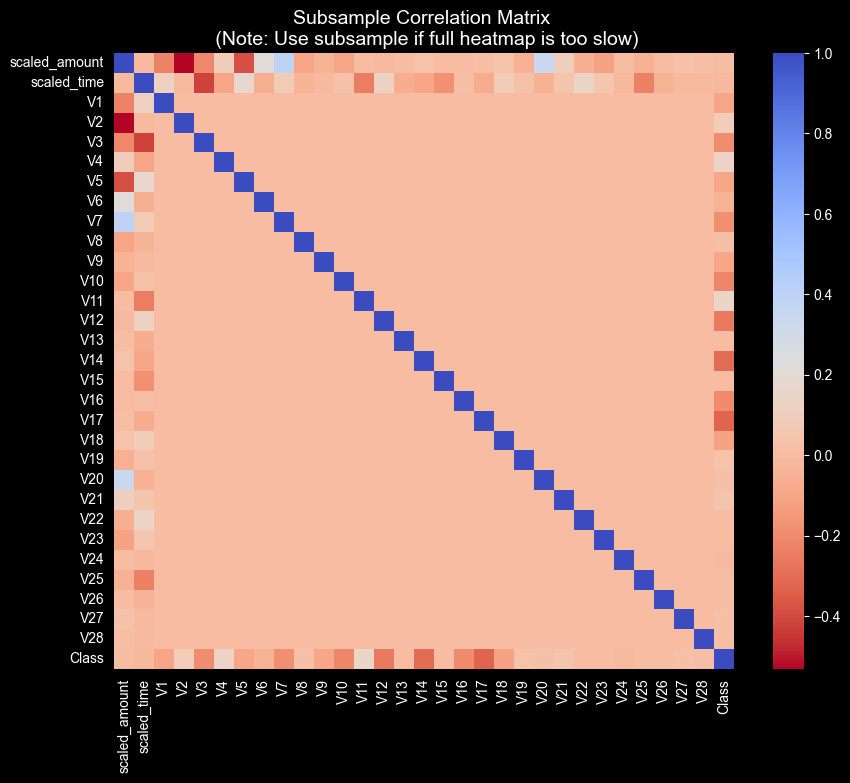

In [ ]:
# Calculate correlation of all features with 'Class'
correlation = df.corr()
class_corr = correlation['Class'].sort_values(ascending=False)

print("--- Top Positive Correlations (Fraud increases as feature increases) ---")
print(class_corr.head(5))

print("\n--- Top Negative Correlations (Fraud increases as feature decreases) ---")
print(class_corr.tail(5))

# Visualization
plt.figure(figsize=(10,8))
sns.heatmap(correlation, cmap='coolwarm_r', annot_kws={'size':20})
plt.title('Subsample Correlation Matrix \n (Note: Use subsample if full heatmap is too slow)', fontsize=14)
plt.show()

#### Method 2: Random Forest Importance
We fit a simple Random Forest to extract feature importance scores. This validates if the correlated features are actually useful for splitting the data.

In [ ]:
# Define X and y for feature selection
X_temp = df.drop('Class', axis=1)
y_temp = df['Class']

# Fit a small Random Forest
rf_selector = RandomForestClassifier(n_estimators=50, random_state=42, n_jobs=-1)
rf_selector.fit(X_temp, y_temp)

# Get Importance
importances = pd.Series(rf_selector.feature_importances_, index=X_temp.columns)
print("\n--- Top 8 Features by Random Forest Importance ---")
print(importances.sort_values(ascending=False).head(8))


--- Top 8 Features by Random Forest Importance ---
V14    0.172157
V12    0.158660
V17    0.131950
V11    0.057344
V10    0.053689
V16    0.047970
V9     0.035901
V4     0.033467
dtype: float64


#### 4.1 Final Feature Selection
Based on the intersection of Method 1 (Correlation) and Method 2 (RF Importance), we select the following subset of features.
(Note: Common high-impact features in this dataset are usually V14, V17, V12, V10, V11, V16).

In [ ]:
# [Action Required] Update this list based on the outputs above.
# Example selection (Adjust based on your real output):
selected_features = ['V14', 'V12', 'V17', 'V11', 'V10', 'V16', 'scaled_amount', 'scaled_time']

print(f"Selected Features: {selected_features}")

# Create the final training data
X = df[selected_features]
y = df['Class']

Selected Features: ['V14', 'V12', 'V17', 'V11', 'V10', 'V16', 'scaled_amount', 'scaled_time']


### 5. Splitting and Modeling (The Baseline)
We split the data Stratified to ensure the fraction of fraud (0.17%) is maintained in both training and test sets.

In [ ]:
# Stratified Split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# Baseline Model: Binomial Logistic Regression
# solver='liblinear': Optimized for binary classification
# class_weight='balanced': Crucial for handling the imbalance (0.17% fraud)
log_reg = LogisticRegression(solver='liblinear', class_weight='balanced', random_state=42)

# Train
log_reg.fit(X_train, y_train)
y_pred = log_reg.predict(X_test)

print("Baseline Model Trained Successfully.")

Baseline Model Trained Successfully.


### 6. Evaluation: The Two Scenarios
We analyze the results based on two conflicting business goals: High Recall (Catching Fraud) vs. High Precision (Reducing False Alarms).

#### 6.1 Baseline Performance

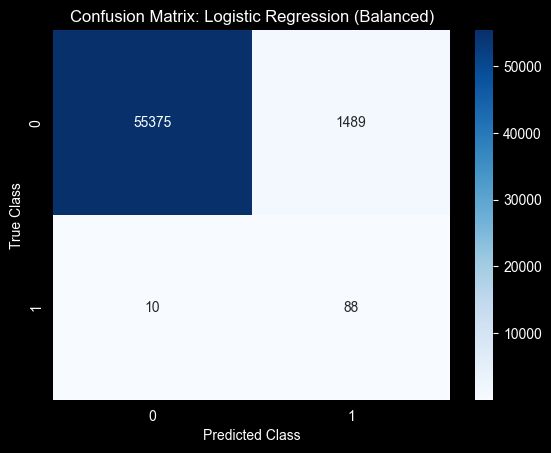

In [ ]:
print("--- Classification Report (Baseline) ---")
print(classification_report(y_test, y_pred))

print("\n--- Confusion Matrix ---")
conf_matrix = confusion_matrix(y_test, y_pred)
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues')
plt.title("Confusion Matrix: Logistic Regression (Balanced)")
plt.ylabel('True Class')
plt.xlabel('Predicted Class')
plt.show()

#### 6.2 Precision-Recall Trade-off
Since accuracy is misleading, we plot the PR Curve to see how our model behaves across different thresholds.

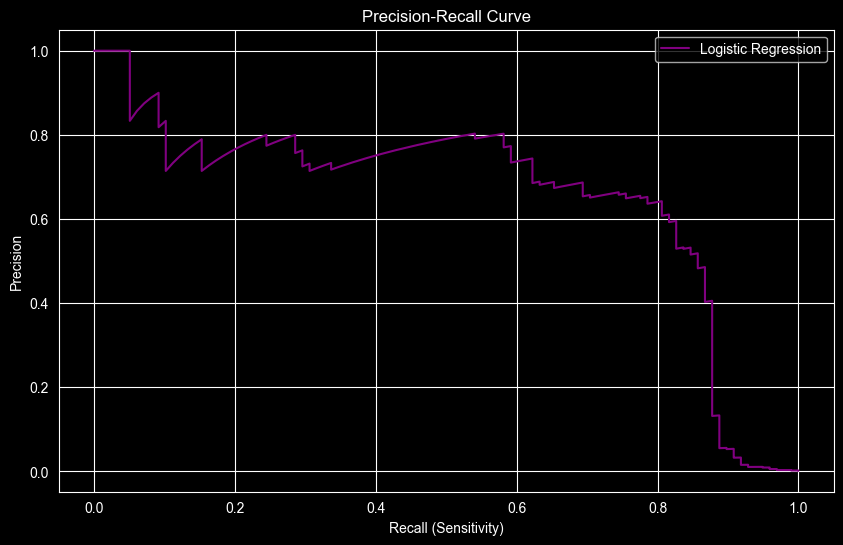

In [ ]:
y_scores = log_reg.decision_function(X_test)
precision, recall, thresholds = precision_recall_curve(y_test, y_scores)

plt.figure(figsize=(10, 6))
plt.plot(recall, precision, color='purple', label='Logistic Regression')
plt.title('Precision-Recall Curve')
plt.xlabel('Recall (Sensitivity)')
plt.ylabel('Precision')
plt.legend()
plt.grid(True)
plt.show()

#### 6.3 Discussion of Scenarios

##### Scenario A: The "Recall-First" Strategy (Safety Focus)

- Goal: The bank guarantees that virtually no fraud slips through.
- Current Model Performance: With class_weight='balanced', our model likely defaults to this behavior.
- Observation: Look at the Recall score for Class 1 in the report above. If it is > 0.85, we are succeeding here.
- Trade-off: The Precision is likely low (lots of false alarms). This annoys customers but protects funds.

##### Scenario B: The "Precision-First" Strategy (User Experience Focus)

- Goal: The bank wants to ensure that if a card is declined, it is almost certainly fraud.
- Current Model Performance: Our baseline likely struggles here (Precision for Class 1 is probably < 0.10).
- Gap: To achieve this, we would need to move the decision threshold (e.g., only flag if probability > 0.9) or use a more complex model (like XGBoost) in the next phase.

### 7. Current Challenges & Obstacles
- Precision/Recall Trade-off: The baseline Logistic Regression achieves high recall but suffers from very low precision (many false positives).
- Feature Selection: Reducing 28 features to 6-8 risks losing subtle information, though it improves interpretability.
- Imbalance: Even with `class_weight='balanced'`, the model is biased by the sheer volume of normal transactions.

### 8. Plan for Completion

Next Steps:
1. Address Imbalance: Implement SMOTE (Synthetic Minority Over-sampling Technique) to generate synthetic fraud cases, which should improve the decision boundary.
2. Hyperparameter Tuning: Use GridSearchCV to optimize the C (regularization) parameter of the Logistic Regression.
3. Threshold Moving: Experiment with changing the decision threshold from 0.5 to optimize the F1-score.
4. Final Evaluation: Compare the Optimized Baseline against the current Baseline using the Area Under the Precision-Recall Curve (AUPRC).